In [2]:
# Importing libraries
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torchvision import models
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Checking Gpu

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü


#Additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce GTX 1050
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Dataset

In [14]:
# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Normalize the image

## Train-test split

In [ ]:
DATA_PATH = "D:/your data path/"
print("DATA_PATH = ",DATA_PATH)

In [29]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.80 * len(data)) 
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset has 5631 data points.
Train Dataset has 4504 data points
Test Dataset has 1127 data points.


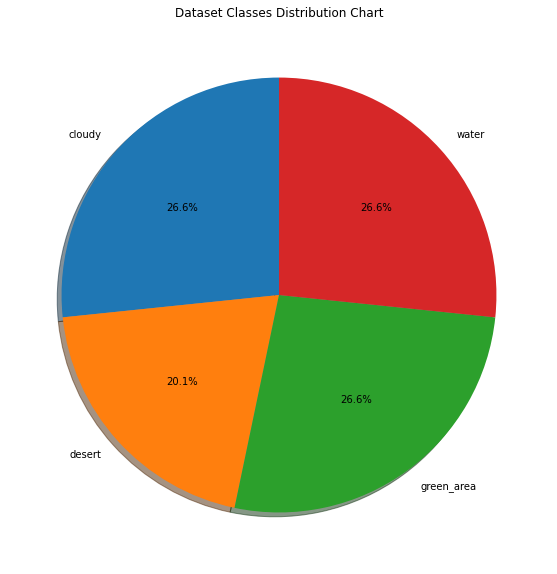

{'cloudy': 1499, 'desert': 1130, 'green_area': 1499, 'water': 1499}


In [30]:
# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

# Model

In [99]:
# Defining hyperparameters
batch_size = 32
num_epochs = 5
learning_rate = 0.0003

In [100]:
# Defining Model
model = models.densenet121(pretrained= True)

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.Linear(1024,460),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(460, 5)
)

model.classifier = fc

model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
total_step = len(train_loader)
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []

# Training 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        epoch_start_time = time.time()
        running_loss = 0.0
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time



arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

# Prediction
with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the ' + str(len(test_dataset)) + ' test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [563/564], Loss: 0.0264: Batch Loss : 4.692127527817952e-05
Epoch [2/5], Step [563/564], Loss: 0.0431: Batch Loss : 7.654279205769459e-05
Epoch [3/5], Step [563/564], Loss: 0.0114: Batch Loss : 2.026121871509518e-05
Epoch [4/5], Step [563/564], Loss: 0.2217: Batch Loss : 0.0003937612524252802
Epoch [5/5], Step [563/564], Loss: 0.0381: Batch Loss : 6.764761269833648e-05
Test Accuracy of the model on the 1127 test images: 97.42451154529307 %


In [103]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training} sn")

Total Training Time : 702.168116569519 sn


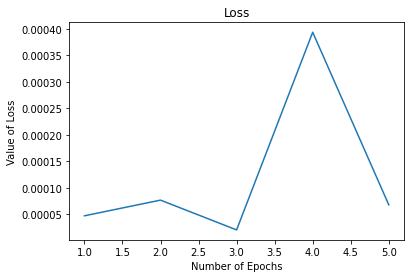

In [104]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

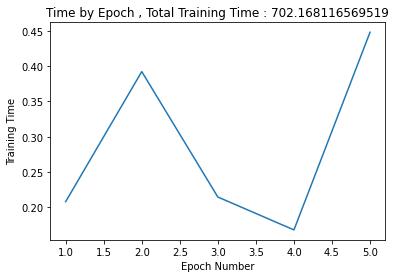

In [105]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

In [106]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

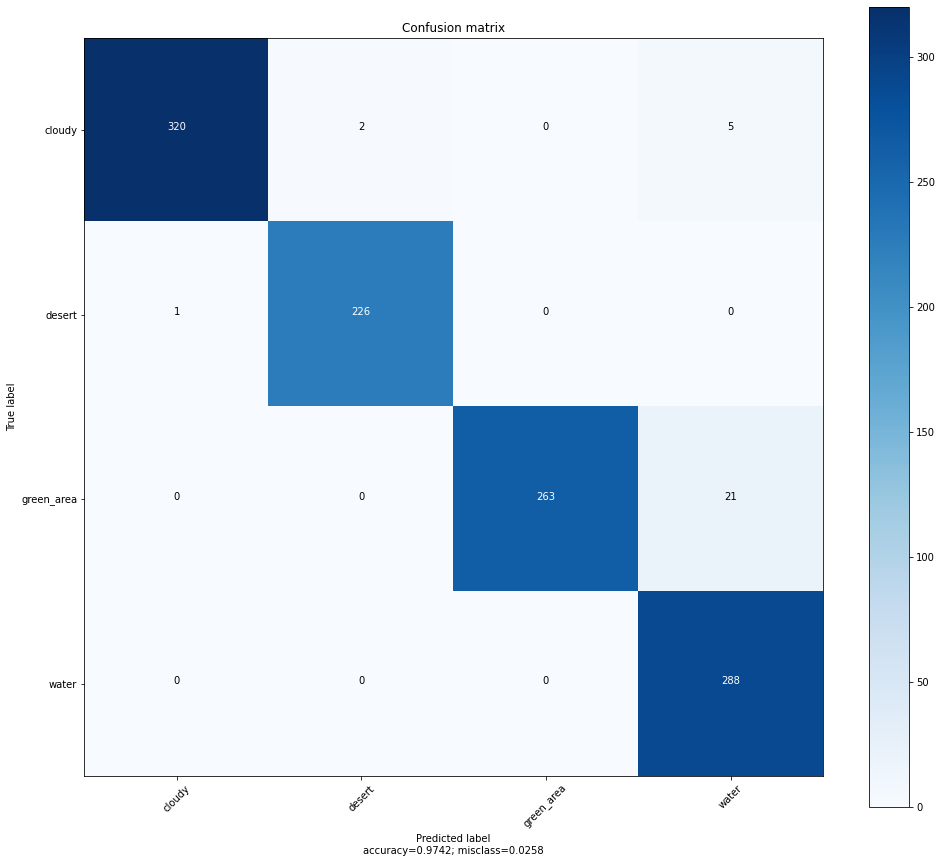

The Accuracy : 97.42451154529307
The Precision : 97.63275644018074
The Recall : 97.50610809639527
The F1 Score : 97.48700801901488


In [107]:
from sklearn import metrics
# from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= class_names_train, title='Confusion matrix' , normalize= False)


print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")